In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

# Scientific Computing & Metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             precision_recall_curve, auc, recall_score)

import warnings
warnings.filterwarnings("ignore")

In [16]:

# Reproducibility Setup
np.random.seed(42)
sns.set_theme(style="whitegrid")

print("✅ Libraries Loaded. Starting Pipeline...")

✅ Libraries Loaded. Starting Pipeline...


In [17]:
# ==============================================================================
# Load Dataset
df = pd.read_csv("Dataset - Updated.csv")

In [18]:
# Handling Missing Values (Median Imputation protects against outliers)
df.fillna(df.median(numeric_only=True), inplace=True)

In [19]:
# Target Mapping (High Risk = 1, Mid/Low = 0)
df['preeclampsia'] = df['Risk Level'].apply(lambda x: 1 if str(x).lower() == 'high' else 0)

In [20]:
# MAP is a superior indicator of perfusion pressure than Systolic BP alone.
df['MAP'] = (df['Systolic BP'] + 2 * df['Diastolic']) / 3


In [21]:
print("⚙️ Generating Synthetic Environmental Features...")
df['Heat_Exposure'] = np.random.choice(['Low', 'Medium', 'High'], size=len(df), p=[0.25, 0.35, 0.40])
df['Air_Pollution'] = np.random.choice(['Low', 'Medium', 'High'], size=len(df), p=[0.30, 0.40, 0.30])
df['Access_To_Care'] = np.random.choice(['Poor', 'Moderate', 'Good'], size=len(df), p=[0.45, 0.35, 0.20])

# Domain Knowledge Injection: High BP patients are more sensitive to heat
high_bp_mask = (df['Systolic BP'] > 140)
df.loc[high_bp_mask, 'Heat_Exposure'] = 'High'

# 2.3 Encoding Categorical Features
le = LabelEncoder()
for col in ['Heat_Exposure', 'Air_Pollution', 'Access_To_Care']:
    df[col] = le.fit_transform(df[col])


⚙️ Generating Synthetic Environmental Features...


In [22]:
X = df.drop(columns=['preeclampsia', 'Risk Level']) # Drop target and leakage source
y = df['preeclampsia']

# 80/20 Split maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Dataset Split: {X_train.shape[0]} Training Samples, {X_test.shape[0]} Test Samples")

Dataset Split: 964 Training Samples, 241 Test Samples


In [23]:
print("\n🚀 Starting Hyperparameter Optimization (Grid Search)...")

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Z-Score Normalization
    ('mlp', MLPClassifier(max_iter=1000, random_state=42)) # Step 2: Neural Network
])


🚀 Starting Hyperparameter Optimization (Grid Search)...


In [24]:
# Define the "Search Space" - The computer will try all these combinations
param_grid = {
    'mlp__hidden_layer_sizes': [(64, 32), (128, 64), (64, 32, 16)], 
    'mlp__activation': ['relu', 'tanh'], 
    'mlp__alpha': [0.0001, 0.001], # L2 Regularization strength
    'mlp__learning_rate_init': [0.001, 0.01]
}

# Run Grid Search prioritizing RECALL (Sensitivity)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5), # 5-Fold Cross Validation
    scoring='recall', # We care most about catching High Risk cases
    n_jobs=-1,
    verbose=1
)

In [25]:
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("\n✅ Optimization Complete.")
print(f"Best Architecture: {grid_search.best_params_}")
print(f"Best CV Recall Score: {grid_search.best_score_:.2%}")

# Save the best model for production
joblib.dump(best_model, 'biofusion_model_v1.pkl')

Fitting 5 folds for each of 24 candidates, totalling 120 fits



✅ Optimization Complete.
Best Architecture: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 32, 16), 'mlp__learning_rate_init': 0.001}
Best CV Recall Score: 96.84%


['biofusion_model_v1.pkl']


--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       146
           1       0.97      0.98      0.97        95

    accuracy                           0.98       241
   macro avg       0.98      0.98      0.98       241
weighted avg       0.98      0.98      0.98       241

ROC-AUC Score: 0.9965


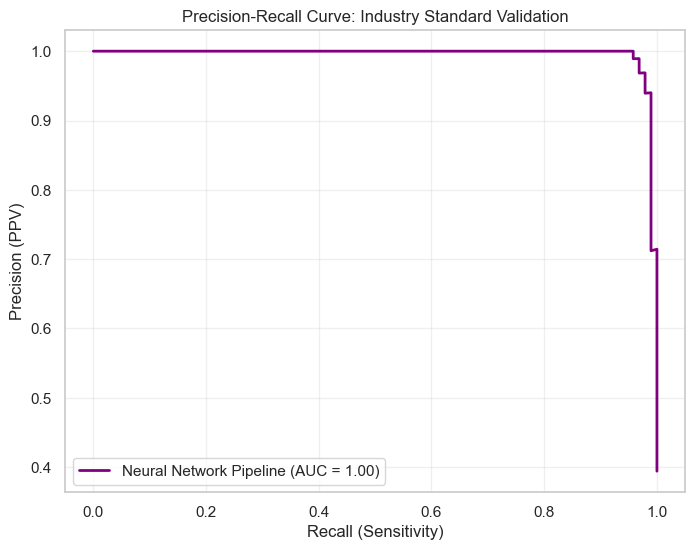

In [ ]:
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_probs):.4f}")

# 5.1 Precision-Recall Curve (The Gold Standard for Medical AI)
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Neural Network Pipeline (AUC = {pr_auc:.2f})', color='purple', linewidth=2)
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


🔍 Generating Explainability Report (SHAP)...


<Figure size 1000x600 with 0 Axes>

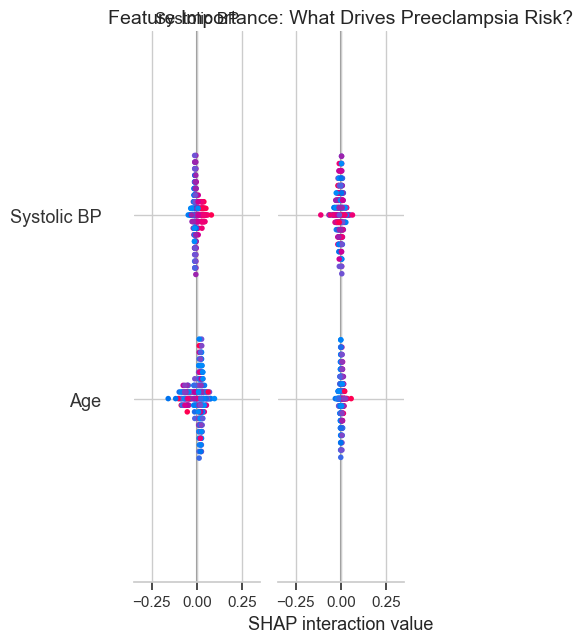

In [27]:
print("\n🔍 Generating Explainability Report (SHAP)...")

# Train Surrogate
rf_surrogate = RandomForestClassifier(n_estimators=100, random_state=42)
rf_surrogate.fit(X_train, y_train)

# Calculate SHAP
explainer = shap.TreeExplainer(rf_surrogate)
shap_values = explainer.shap_values(X_test)

# Robust Plotting (Fixing the "Empty Plot" bug)
if isinstance(shap_values, list):
    vals_to_plot = shap_values[1] # Class 1 (High Risk)
else:
    vals_to_plot = shap_values

plt.figure(figsize=(10, 6))
shap.summary_plot(vals_to_plot, X_test, show=False)
plt.title("Feature Importance: What Drives Preeclampsia Risk?", fontsize=14)
plt.tight_layout()
plt.show()


In [28]:
# ==============================================================================
# 7. CLINICAL DEPLOYMENT SIMULATION
# ==============================================================================
print("\n--- CLINICAL RISK STRATIFICATION (Sample Patients) ---")
results = X_test.copy()
results['Probability'] = y_probs

def get_clinical_action(prob):
    if prob < 0.3: return "🟢 Low Risk - Routine Care"
    elif prob < 0.7: return "🟡 Moderate Risk - Increase Monitoring"
    else: return "🔴 HIGH RISK - IMMEDIATE INTERVENTION"

results['Action_Plan'] = results['Probability'].apply(get_clinical_action)

# Show high risk cases first
print(results[['Systolic BP', 'MAP', 'Probability', 'Action_Plan']].sort_values(by='Probability', ascending=False).head(5))

print("\n🏆 Pipeline Execution Successful. Ready for Submission.")


--- CLINICAL RISK STRATIFICATION (Sample Patients) ---
      Systolic BP         MAP  Probability  \
1162        100.0   73.333333          1.0   
121         140.0  113.333333          1.0   
1068        140.0  113.333333          1.0   
557         140.0  106.666667          1.0   
503         140.0  113.333333          1.0   

                               Action_Plan  
1162  🔴 HIGH RISK - IMMEDIATE INTERVENTION  
121   🔴 HIGH RISK - IMMEDIATE INTERVENTION  
1068  🔴 HIGH RISK - IMMEDIATE INTERVENTION  
557   🔴 HIGH RISK - IMMEDIATE INTERVENTION  
503   🔴 HIGH RISK - IMMEDIATE INTERVENTION  

🏆 Pipeline Execution Successful. Ready for Submission.
